## Origignal code for FSRO algorithm on speed reducer problem 


In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def objective(x):
    x1, x2, x3, x4, x5, x6, x7 = x
    term1 = 0.7854 * x1 * x2**2 * (3.3333 * x3**2 + 14.9334 * x3 - 43.0934)
    term2 = -1.508 * x1 * (x6**2 + x7**2)
    term3 = 7.4777 * (x6**3 + x7**3)
    term4 = 0.7854 * (x4 * x6**2 + x5 * x7**2)
    return term1 + term2 + term3 + term4

In [4]:
def constraints(x):
    x1, x2, x3, x4, x5, x6, x7 = x
    g = [0]*11
    g[0] = 1 - (27 / (x1 * x2**2 * x3))
    g[1] = 1 - (397.5 / (x1 * x2**2 * x3**2))
    g[2] = (x4 / 1.5) - 1
    g[3] = (x5 / 1.5) - 1
    g[4] = (1.93 * x4**3 / (x2 * x3**2)) - 1
    g[5] = (1.93 * x5**3 / (x2 * x3**2)) - 1
    g[6] = 1 - (1100 / ((x6**2) * x4))
    g[7] = 1 - (850 / ((x7**2) * x5))
    g[8] = x6 - 3
    g[9] = x7 - 3
    g[10] = 0.32 - x2
    return g

In [5]:

def is_feasible(x):
    return all([g <= 0 for g in constraints(x)])

# === FSRO Parameters ===
POP_SIZE = 40
DIM = 7
MAX_GEN = 1000
X_MIN = [2.6, 0.7, 17, 7.3, 7.8, 2.9, 5.0]
X_MAX = [3.6, 0.8, 28, 8.3, 8.3, 3.9, 5.5]
INTEGER_IDX = [2]
w1, d1, w2, d2 = 0.75, 40, 1, 20
DECISION_DIST = 6
MAX_DIST = 80

In [6]:
def initialize_population():
    frogs = np.random.uniform(0, 1, (POP_SIZE//2, DIM))
    snakes = np.random.uniform(0, 1, (POP_SIZE//2, DIM))
    return decode(frogs), decode(snakes)

def decode(pop):
    decoded = np.array(pop)
    for i in range(DIM):
        decoded[:, i] = X_MIN[i] + pop[:, i] * (X_MAX[i] - X_MIN[i])
    for idx in INTEGER_IDX:
        decoded[:, idx] = np.round(decoded[:, idx])
    return decoded

def normalize(pop):
    norm = np.zeros_like(pop)
    for i in range(DIM):
        norm[:, i] = (pop[:, i] - X_MIN[i]) / (X_MAX[i] - X_MIN[i])
    return norm

In [7]:
def uniform_crossover(p1, p2):
    mask = np.random.rand(DIM) > 0.5
    return np.where(mask, p1, p2)

def two_point_crossover(p1, p2):
    c1, c2 = sorted(np.random.choice(DIM, 2, replace=False))
    child = p1.copy()
    child[c1:c2] = p2[c1:c2]
    return child

def capture(frog, snake):
    matches = np.sum(np.isclose(frog, snake, atol=1e-3))
    dist = MAX_DIST * (DIM - matches) / DIM
    order = 'first' if dist <= DECISION_DIST else 'second'
    avoidance = (w1 * dist + d1) / 100 if order == 'first' else (w2 * dist + d2) / 100
    if np.random.rand() > avoidance:
        idx = np.random.randint(DIM)
        frog[idx] += np.random.uniform(-0.1, 0.1)
        frog[idx] = np.clip(frog[idx], X_MIN[idx], X_MAX[idx])
        if idx in INTEGER_IDX:
            frog[idx] = round(frog[idx])
    return frog

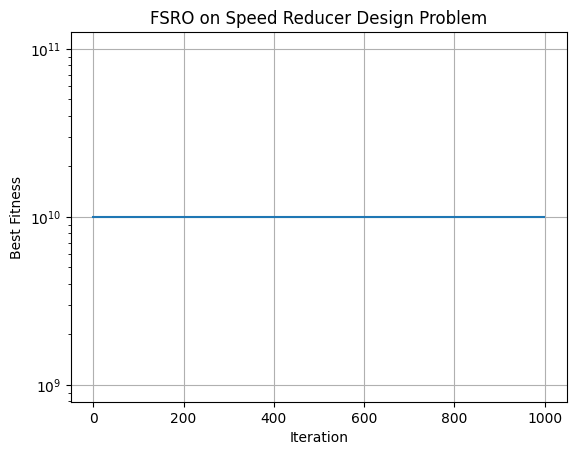

10000000000.0 [ 2.64845025  0.76938981 26.          7.56367959  7.93033139  3.21994526
  5.47462032]


In [8]:
frogs, snakes = initialize_population()
best_fitness_curve = []
global_best = float('inf')
global_best_x = None

for gen in range(MAX_GEN):
    # Crossover
    for i in range(len(frogs)):
        partner = frogs[np.random.randint(len(frogs))]
        frogs[i] = uniform_crossover(frogs[i], partner)

    for i in range(len(snakes)):
        partner = snakes[np.random.randint(len(snakes))]
        snakes[i] = two_point_crossover(snakes[i], partner)

    # Capture
    for i in range(len(frogs)):
        predator = snakes[np.random.randint(len(snakes))]
        frogs[i] = capture(frogs[i], predator)

    # Combine & Evaluate
    population = np.vstack((frogs, snakes))
    fitnesses = np.array([objective(ind) if is_feasible(ind) else 1e10 for ind in population])
    best_idx = np.argmin(fitnesses)

    if fitnesses[best_idx] < global_best:
        global_best = fitnesses[best_idx]
        global_best_x = population[best_idx].copy()

    best_fitness_curve.append(global_best)

    # Shuffle & normalize for next iteration
    norm_pop = normalize(population)
    frogs = decode(norm_pop[:POP_SIZE//2])
    snakes = decode(norm_pop[POP_SIZE//2:])

# === Results ===
plt.plot(best_fitness_curve)
plt.title("FSRO on Speed Reducer Design Problem")
plt.xlabel("Iteration")
plt.ylabel("Best Fitness")
plt.yscale("log")
plt.grid(True)
plt.show()

print(global_best, global_best_x)
